# Neo4j 를 활용한 GraphRAG 에이전트 구축

이 단계에서는 GraphRAG 에이전트 구축에 필요한 환경을 설정하고 Neo4j 그래프 데이터베이스에 연결합니다.

### 📋 사전 준비사항
- **Neo4j 샌드박스 계정** 생성 (무료): https://sandbox.neo4j.com/
- **Movie Graph** 데이터셋 선택 (영화, 배우, 감독 관계 데이터)

### 🔗 연결 정보 설정
아래 코드에서 Neo4j 샌드박스에서 제공하는 연결 정보를 입력해야 합니다.

In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("LangGraph-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Tutorial


In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):  # 그래프의 상태를 정의하는 클래스
    messages: Annotated[list, add_messages]  # 메시지 누적 (사용자 질문, LLM 응답 등)
    db_outputs: list  # 데이터베이스 조회 결과를 저장하는 리스트


# StateGraph 생성 - 대화 흐름을 관리하는 그래프 객체
graph_builder = StateGraph(State)

## 🔍 Cypher 쿼리 생성

이 단계에서는 사용자의 자연어 질문을 **Cypher 쿼리** 로 변환합니다.

### 💡 Cypher란?

**Cypher** 는 Neo4j 그래프 데이터베이스에서 사용하는 **선언적 쿼리 언어** 입니다. SQL이 관계형 데이터베이스에서 사용되는 것처럼, Cypher는 그래프 데이터베이스에서 노드와 관계를 조회하는 데 사용됩니다.

### 🎯 주요 작업

1. **스키마 정보 추출**: 그래프 데이터베이스의 노드, 관계, 속성 정보 수집
2. **Few-shot 학습**: 예제를 통해 LLM이 올바른 Cypher 문법 학습
3. **자연어 → Cypher 변환**: 사용자 질문을 실행 가능한 Cypher 쿼리로 변환

### 📊 **그래프 스키마 추출**

**스키마(Schema)** 는 데이터베이스의 구조를 정의하는 청사진입니다. GraphRAG에서 정확한 Cypher 쿼리를 생성하려면 다음 정보가 필요합니다:

#### 🔸 노드(Node) 정보
- **라벨(Label)**: 노드의 유형 (예: Person, Movie)
- **속성(Property)**: 노드가 가진 데이터 필드 (예: name, born, title)
- **데이터 타입**: 각 속성의 데이터 형태 (STRING, INTEGER 등)

#### 🔸 관계(Relationship) 정보  
- **타입(Type)**: 관계의 종류 (예: ACTED_IN, DIRECTED)
- **방향(Direction)**: 관계의 방향성 (Person → Movie)
- **속성**: 관계가 가진 추가 정보 (예: roles, rating)

이 정보를 LLM에 제공하여 문법적으로 올바르고 의미적으로 정확한 Cypher 쿼리를 생성할 수 있습니다.

In [4]:
from neo4j import GraphDatabase, basic_auth
import os

# 환경변수에서 Neo4j 연결 정보 가져오기
neo4j_uri = os.environ["NEO4J_URI"]
neo4j_username = os.environ["NEO4J_USERNAME"]
neo4j_password = os.environ["NEO4J_PASSWORD"]

# Neo4j 데이터베이스 드라이버 생성
driver = GraphDatabase.driver(
    neo4j_uri, auth=basic_auth(neo4j_username, neo4j_password)
)

In [5]:
from neo4j.time import Date


def get_node_datatype(value):
    """
    입력된 노드 Value의 데이터 타입을 반환하는 함수
    """
    # 값의 타입에 따라 문자열로 데이터 타입 반환
    if isinstance(value, str):
        return "STRING"
    elif isinstance(value, int):
        return "INTEGER"
    elif isinstance(value, float):
        return "FLOAT"
    elif isinstance(value, bool):
        return "BOOLEAN"
    elif isinstance(value, list):
        # 리스트인 경우 첫 번째 요소의 타입을 기반으로 판단
        return f"LIST[{get_node_datatype(value[0])}]" if value else "LIST"
    elif isinstance(value, Date):
        return "DATE"
    else:
        return "UNKNOWN"


def get_schema_dict():
    """
    Graph DB의 정보를 받아 노드 및 관계의 프로퍼티를 추출하고 스키마 딕셔너리를 반환하는 함수
    """
    with driver.session() as session:
        # 노드 프로퍼티 및 타입 추출하는 Cypher 쿼리
        node_query = """
        MATCH (n)
        WITH DISTINCT labels(n) AS node_labels, keys(n) AS property_keys, n
        UNWIND node_labels AS label
        UNWIND property_keys AS key
        RETURN label, key, n[key] AS sample_value
        """
        nodes = session.run(node_query)  # 노드 정보 조회

        # 관계 프로퍼티 및 타입 추출하는 Cypher 쿼리
        rel_query = """
        MATCH ()-[r]->()
        WITH DISTINCT type(r) AS rel_type, keys(r) AS property_keys, r
        UNWIND property_keys AS key
        RETURN rel_type, key, r[key] AS sample_value
        """
        relationships = session.run(rel_query)  # 관계 정보 조회

        # 관계 유형 및 방향 추출하는 Cypher 쿼리
        rel_direction_query = """
        MATCH (a)-[r]->(b)
        RETURN DISTINCT labels(a) AS start_label, type(r) AS rel_type, labels(b) AS end_label
        ORDER BY start_label, rel_type, end_label
        """
        rel_directions = session.run(rel_direction_query)  # 관계 방향 정보 조회

        # 스키마 딕셔너리 초기화
        schema = {"nodes": {}, "relationships": {}, "relations": []}

        # 노드 정보를 스키마 딕셔너리에 저장
        for record in nodes:
            label = record["label"]
            key = record["key"]
            sample_value = record["sample_value"]  # 데이터 타입 추론을 위한 샘플 데이터
            inferred_type = get_node_datatype(sample_value)  # 데이터 타입 추론
            if label not in schema["nodes"]:
                schema["nodes"][label] = {}
            schema["nodes"][label][key] = inferred_type

        # 관계 정보를 스키마 딕셔너리에 저장
        for record in relationships:
            rel_type = record["rel_type"]
            key = record["key"]
            sample_value = record["sample_value"]  # 데이터 타입 추론을 위한 샘플 데이터
            inferred_type = get_node_datatype(sample_value)  # 데이터 타입 추론
            if rel_type not in schema["relationships"]:
                schema["relationships"][rel_type] = {}
            schema["relationships"][rel_type][key] = inferred_type

        # 관계 방향 정보를 스키마 딕셔너리에 저장
        for record in rel_directions:
            start_label = record["start_label"][0]
            rel_type = record["rel_type"]
            end_label = record["end_label"][0]
            schema["relations"].append(
                f"(:{start_label})-[:{rel_type}]->(:{end_label})"
            )

        return schema


def get_schema_str(schema):
    """
    스키마 딕셔너리를 LLM에 제공하기 위해 원하는 형태로 formatting 하는 함수
    """
    result = []

    # 노드 프로퍼티를 문자열 형태로 변환
    result.append("Node properties:")
    for label, properties in schema["nodes"].items():
        props = ", ".join(f"{k}: {v}" for k, v in properties.items())
        result.append(f"{label} {{{props}}}")

    # 관계 프로퍼티를 문자열 형태로 변환
    result.append("Relationship properties:")
    for rel_type, properties in schema["relationships"].items():
        props = ", ".join(f"{k}: {v}" for k, v in properties.items())
        result.append(f"{rel_type} {{{props}}}")

    # 관계 정보를 문자열 형태로 변환
    result.append("The relationships:")
    for relation in schema["relations"]:
        result.append(relation)

    return "\n".join(result)  # 모든 정보를 개행으로 연결하여 반환

In [6]:
# 스키마 정보를 딕셔너리 형태로 추출 후 문자열로 변환
schema = get_schema_str(get_schema_dict())

In [7]:
print(schema)

Node properties:
Movie {tagline: STRING, title: STRING, released: INTEGER}
Person {name: STRING, born: INTEGER}
Relationship properties:
ACTED_IN {roles: LIST[STRING]}
REVIEWED {summary: STRING, rating: INTEGER}
The relationships:
(:Person)-[:ACTED_IN]->(:Movie)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:FOLLOWS]->(:Person)
(:Person)-[:PRODUCED]->(:Movie)
(:Person)-[:REVIEWED]->(:Movie)
(:Person)-[:WROTE]->(:Movie)


In [8]:
def explore_graph_database():
    """
    그래프 데이터베이스의 기본 정보를 조회하고 출력하는 함수
    """
    with driver.session() as session:
        print("🔍 === 그래프 데이터베이스 정보 탐색 ===\n")

        # 1. 전체 노드 개수 조회
        node_count_query = "MATCH (n) RETURN count(n) AS total_nodes"
        result = session.run(node_count_query).single()
        print(f"📊 전체 노드 개수: {result['total_nodes']:,}개")

        # 2. 전체 관계 개수 조회
        rel_count_query = "MATCH ()-[r]->() RETURN count(r) AS total_relationships"
        result = session.run(rel_count_query).single()
        print(f"🔗 전체 관계 개수: {result['total_relationships']:,}개")

        # 3. 노드 라벨별 개수 조회
        print(f"\n📋 노드 라벨별 개수:")
        label_count_query = """
        MATCH (n)
        RETURN labels(n) AS node_labels, count(n) AS count
        ORDER BY count DESC
        """
        results = session.run(label_count_query)
        for record in results:
            labels = ", ".join(record["node_labels"])
            count = record["count"]
            print(f"   • {labels}: {count:,}개")

        # 4. 관계 타입별 개수 조회
        print(f"\n🔗 관계 타입별 개수:")
        rel_type_query = """
        MATCH ()-[r]->()
        RETURN type(r) AS relationship_type, count(r) AS count
        ORDER BY count DESC
        """
        results = session.run(rel_type_query)
        for record in results:
            rel_type = record["relationship_type"]
            count = record["count"]
            print(f"   • {rel_type}: {count:,}개")

        # 5. 샘플 노드 조회 (각 라벨별로 3개씩)
        print(f"\n🎯 샘플 데이터:")
        sample_query = """
        MATCH (n)
        WITH labels(n) AS node_labels, collect(n)[0..3] AS samples
        RETURN node_labels, samples
        """
        results = session.run(sample_query)

        for record in results:
            labels = ", ".join(record["node_labels"])
            samples = record["samples"]
            print(f"\n   📄 {labels} 샘플:")

            for i, sample in enumerate(samples, 1):
                # 노드의 속성들을 보기 좋게 출력
                properties = dict(sample)
                prop_str = ", ".join(
                    [f"{k}: {v}" for k, v in list(properties.items())[:3]]
                )  # 처음 3개 속성만
                print(f"      {i}. {prop_str}")

        print("\n" + "=" * 50)


# 데이터베이스 정보 탐색 실행
explore_graph_database()

🔍 === 그래프 데이터베이스 정보 탐색 ===

📊 전체 노드 개수: 171개
🔗 전체 관계 개수: 253개

📋 노드 라벨별 개수:
   • Person: 133개
   • Movie: 38개

🔗 관계 타입별 개수:
   • ACTED_IN: 172개
   • DIRECTED: 44개
   • PRODUCED: 15개
   • WROTE: 10개
   • REVIEWED: 9개
   • FOLLOWS: 3개

🎯 샘플 데이터:

   📄 Movie 샘플:
      1. tagline: Welcome to the Real World, title: The Matrix, released: 1999
      2. tagline: Free your mind, title: The Matrix Reloaded, released: 2003
      3. tagline: Everything that has a beginning has an end, title: The Matrix Revolutions, released: 2003

   📄 Person 샘플:
      1. born: 1964, name: Keanu Reeves
      2. born: 1967, name: Carrie-Anne Moss
      3. born: 1961, name: Laurence Fishburne



In [9]:
def analyze_node_properties():
    """
    각 노드 타입별로 보유하고 있는 속성(Property)들을 상세 분석하는 함수
    """
    with driver.session() as session:
        print("🔍 === 노드 속성 상세 분석 ===\n")

        # 모든 노드 라벨 가져오기
        labels_query = """
        MATCH (n)
        RETURN DISTINCT labels(n) AS node_labels
        """
        label_results = session.run(labels_query)

        for label_record in label_results:
            labels = label_record["node_labels"]
            if not labels:  # 라벨이 없는 노드 제외
                continue

            label_name = labels[0]  # 첫 번째 라벨 사용
            print(f"📄 {label_name} 노드 분석:")

            # 해당 라벨의 모든 속성과 데이터 타입 분석
            property_analysis_query = f"""
            MATCH (n:{label_name})
            WITH keys(n) AS all_keys
            UNWIND all_keys AS key
            RETURN key, count(*) AS frequency
            ORDER BY frequency DESC
            """

            prop_results = session.run(property_analysis_query)

            print("   🔸 속성 목록 (빈도순):")
            for prop_record in prop_results:
                key = prop_record["key"]
                frequency = prop_record["frequency"]

                # 해당 속성의 샘플 값과 데이터 타입 조회
                sample_query = f"""
                MATCH (n:{label_name})
                WHERE n.{key} IS NOT NULL
                RETURN DISTINCT n.{key} AS sample_value, count(*) AS count
                ORDER BY count DESC
                LIMIT 5
                """

                try:
                    sample_results = session.run(sample_query)
                    samples = []
                    data_types = set()

                    for sample_record in sample_results:
                        sample_value = sample_record["sample_value"]
                        samples.append(str(sample_value))

                        # 데이터 타입 판별
                        if isinstance(sample_value, str):
                            data_types.add("STRING")
                        elif isinstance(sample_value, int):
                            data_types.add("INTEGER")
                        elif isinstance(sample_value, float):
                            data_types.add("FLOAT")
                        elif isinstance(sample_value, bool):
                            data_types.add("BOOLEAN")
                        elif isinstance(sample_value, list):
                            data_types.add("LIST")
                        else:
                            data_types.add("OTHER")

                    data_type_str = ", ".join(sorted(data_types))
                    sample_str = ", ".join(samples[:3])  # 처음 3개 샘플만

                    print(f"      • {key} ({data_type_str}) - {frequency}개")
                    print(f"        샘플: {sample_str}")

                except Exception as e:
                    print(f"      • {key} - {frequency}개 (샘플 조회 실패)")

            print()  # 노드 타입 간 구분을 위한 빈 줄

        print("=" * 50)


# 노드 속성 분석 실행
analyze_node_properties()

🔍 === 노드 속성 상세 분석 ===

📄 Movie 노드 분석:
   🔸 속성 목록 (빈도순):
      • title (STRING) - 38개
        샘플: A League of Their Own, Apollo 13, As Good as It Gets
      • released (INTEGER) - 38개
        샘플: 1999, 1992, 1996
      • tagline (STRING) - 37개
        샘플: Free your mind, Everything that has a beginning has an end, Evil has its winning ways

📄 Person 노드 분석:
   🔸 속성 목록 (빈도순):
      • name (STRING) - 133개
        샘플: Al Pacino, Angela Scope, Annabella Sciorra
      • born (INTEGER) - 128개
        샘플: 1967, 1956, 1961



In [10]:
def analyze_relationships():
    """
    그래프의 관계(Relationship) 구조를 상세 분석하는 함수
    """
    with driver.session() as session:
        print("🔍 === 관계 구조 상세 분석 ===\n")

        # 1. 관계 패턴 분석 (시작 노드 → 관계 → 끝 노드)
        print("🔗 관계 패턴 분석:")
        relationship_pattern_query = """
        MATCH (start)-[r]->(end)
        RETURN 
            labels(start)[0] AS start_label,
            type(r) AS relationship_type,
            labels(end)[0] AS end_label,
            count(*) AS count
        ORDER BY count DESC
        """

        pattern_results = session.run(relationship_pattern_query)

        for record in pattern_results:
            start_label = record["start_label"]
            rel_type = record["relationship_type"]
            end_label = record["end_label"]
            count = record["count"]

            print(f"   • ({start_label})-[{rel_type}]->({end_label}): {count:,}개")

        print(f"\n🔸 관계별 속성 분석:")

        # 2. 각 관계 타입별 속성 분석
        rel_types_query = """
        MATCH ()-[r]->()
        RETURN DISTINCT type(r) AS relationship_type
        """

        rel_types = session.run(rel_types_query)

        for rel_record in rel_types:
            rel_type = rel_record["relationship_type"]
            print(f"\n   📋 {rel_type} 관계:")

            # 해당 관계 타입의 속성들 조회
            rel_properties_query = f"""
            MATCH ()-[r:{rel_type}]->()
            WITH keys(r) AS all_keys
            UNWIND all_keys AS key
            RETURN key, count(*) AS frequency
            ORDER BY frequency DESC
            """

            try:
                prop_results = session.run(rel_properties_query)
                has_properties = False

                for prop_record in prop_results:
                    has_properties = True
                    key = prop_record["key"]
                    frequency = prop_record["frequency"]

                    # 샘플 값 조회
                    sample_query = f"""
                    MATCH ()-[r:{rel_type}]->()
                    WHERE r.{key} IS NOT NULL
                    RETURN DISTINCT r.{key} AS sample_value
                    LIMIT 3
                    """

                    sample_results = session.run(sample_query)
                    samples = [str(record["sample_value"]) for record in sample_results]
                    sample_str = ", ".join(samples) if samples else "N/A"

                    print(f"      • {key}: {frequency}개 (샘플: {sample_str})")

                if not has_properties:
                    print("      • 속성 없음 (단순 관계)")

            except Exception as e:
                print(f"      • 속성 조회 실패: {str(e)}")

        print(f"\n🎯 관계 네트워크 분석:")

        # 3. 노드별 연결 정도 분석 (degree centrality)
        print("   📊 연결 정도가 높은 노드 TOP 10:")

        degree_query = """
        MATCH (n)
        WITH n, 
             size([(n)-[]->() | 1]) AS out_degree,
             size([()-[]->(n) | 1]) AS in_degree
        WITH n, out_degree + in_degree AS total_degree
        WHERE total_degree > 0
        RETURN labels(n)[0] AS node_label, 
               n.name AS node_name,
               n.title AS node_title,
               total_degree
        ORDER BY total_degree DESC
        LIMIT 10
        """

        degree_results = session.run(degree_query)

        for i, record in enumerate(degree_results, 1):
            label = record["node_label"]
            name = record["node_name"] or record["node_title"] or "N/A"
            degree = record["total_degree"]
            print(f"      {i:2d}. {label}: {name} (연결수: {degree})")

        print("\n" + "=" * 50)


# 관계 구조 분석 실행
analyze_relationships()

🔍 === 관계 구조 상세 분석 ===

🔗 관계 패턴 분석:
   • (Person)-[ACTED_IN]->(Movie): 172개
   • (Person)-[DIRECTED]->(Movie): 44개
   • (Person)-[PRODUCED]->(Movie): 15개
   • (Person)-[WROTE]->(Movie): 10개
   • (Person)-[REVIEWED]->(Movie): 9개
   • (Person)-[FOLLOWS]->(Person): 3개

🔸 관계별 속성 분석:

   📋 ACTED_IN 관계:
      • roles: 172개 (샘플: ['Julian Mercer'], ['Shane Falco'], ['Johnny Mnemonic'])

   📋 DIRECTED 관계:
      • 속성 없음 (단순 관계)

   📋 PRODUCED 관계:
      • 속성 없음 (단순 관계)

   📋 WROTE 관계:
      • 속성 없음 (단순 관계)

   📋 FOLLOWS 관계:
      • 속성 없음 (단순 관계)

   📋 REVIEWED 관계:
      • summary: 9개 (샘플: Pretty funny at times, A solid romp, Silly, but fun)
      • rating: 9개 (샘플: 62, 68, 65)

🎯 관계 네트워크 분석:
   📊 연결 정도가 높은 노드 TOP 10:
       1. Movie: A Few Good Men (연결수: 14)
       2. Movie: Jerry Maguire (연결수: 13)
       3. Person: Tom Hanks (연결수: 13)
       4. Movie: Speed Racer (연결수: 12)
       5. Movie: V for Vendetta (연결수: 11)
       6. Movie: Cloud Atlas (연결수: 10)
       7. Person: Lana Wachowski (연결수: 9)
   

In [11]:
def analyze_entities_and_insights():
    """
    그래프 데이터베이스의 엔티티와 비즈니스 인사이트를 분석하는 함수
    """
    with driver.session() as session:
        print("🔍 === 엔티티 및 비즈니스 인사이트 분석 ===\n")

        # 1. 주요 엔티티 통계
        print("📈 주요 엔티티 통계:")

        # 영화 관련 통계
        movie_stats_query = """
        MATCH (m:Movie)
        RETURN 
            count(m) AS total_movies,
            min(m.released) AS earliest_year,
            max(m.released) AS latest_year,
            avg(m.released) AS avg_year
        """

        movie_result = session.run(movie_stats_query).single()
        if movie_result:
            print(f"   🎬 영화:")
            print(f"      • 총 영화 수: {movie_result['total_movies']:,}편")
            print(
                f"      • 연도 범위: {movie_result['earliest_year']} ~ {movie_result['latest_year']}"
            )
            print(f"      • 평균 연도: {movie_result['avg_year']:.0f}")

        # 인물 관련 통계
        person_stats_query = """
        MATCH (p:Person)
        RETURN 
            count(p) AS total_people,
            min(p.born) AS earliest_birth,
            max(p.born) AS latest_birth,
            avg(p.born) AS avg_birth_year
        """

        person_result = session.run(person_stats_query).single()
        if person_result and person_result["total_people"]:
            print(f"\n   👤 인물:")
            print(f"      • 총 인물 수: {person_result['total_people']:,}명")
            if person_result["earliest_birth"]:
                print(
                    f"      • 출생년도 범위: {person_result['earliest_birth']} ~ {person_result['latest_birth']}"
                )
                print(f"      • 평균 출생년도: {person_result['avg_birth_year']:.0f}")

        print(f"\n🎯 비즈니스 인사이트:")

        # 2. 가장 활발한 배우들 (출연 영화 수 기준)
        print("   🏆 가장 많은 영화에 출연한 배우 TOP 10:")
        active_actors_query = """
        MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
        RETURN p.name AS actor_name, count(m) AS movie_count
        ORDER BY movie_count DESC
        LIMIT 10
        """

        actor_results = session.run(active_actors_query)
        for i, record in enumerate(actor_results, 1):
            print(f"      {i:2d}. {record['actor_name']}: {record['movie_count']}편")

        # 3. 가장 활발한 감독들
        print(f"\n   🎬 가장 많은 영화를 연출한 감독 TOP 10:")
        active_directors_query = """
        MATCH (p:Person)-[:DIRECTED]->(m:Movie)
        RETURN p.name AS director_name, count(m) AS movie_count
        ORDER BY movie_count DESC
        LIMIT 10
        """

        director_results = session.run(active_directors_query)
        for i, record in enumerate(director_results, 1):
            print(f"      {i:2d}. {record['director_name']}: {record['movie_count']}편")

        # 4. 연도별 영화 제작 동향
        print(f"\n   📊 연도별 영화 제작 동향 (최근 20년):")
        yearly_movies_query = """
        MATCH (m:Movie)
        WHERE m.released >= 1990
        RETURN m.released AS year, count(m) AS movie_count
        ORDER BY year DESC
        LIMIT 20
        """

        yearly_results = session.run(yearly_movies_query)
        for record in yearly_results:
            year = record["year"]
            count = record["movie_count"]
            bar = "█" * min(count, 20)  # 간단한 바 차트
            print(f"      {year}: {bar} ({count}편)")

        # 5. 협업 네트워크 분석
        print(f"\n   🤝 가장 많은 협업 관계를 가진 인물:")
        collaboration_query = """
        MATCH (p1:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
        WHERE p1 <> p2
        WITH p1, count(DISTINCT p2) AS collaborator_count
        ORDER BY collaborator_count DESC
        LIMIT 10
        RETURN p1.name AS person_name, collaborator_count
        """

        collab_results = session.run(collaboration_query)
        for i, record in enumerate(collab_results, 1):
            print(
                f"      {i:2d}. {record['person_name']}: {record['collaborator_count']}명과 협업"
            )

        # 6. 리뷰 분석 (존재하는 경우)
        review_analysis_query = """
        MATCH (p:Person)-[r:REVIEWED]->(m:Movie)
        RETURN 
            count(r) AS total_reviews,
            avg(r.rating) AS avg_rating,
            min(r.rating) AS min_rating,
            max(r.rating) AS max_rating
        """

        try:
            review_result = session.run(review_analysis_query).single()
            if review_result and review_result["total_reviews"] > 0:
                print(f"\n   ⭐ 리뷰 분석:")
                print(f"      • 총 리뷰 수: {review_result['total_reviews']:,}개")
                print(f"      • 평균 평점: {review_result['avg_rating']:.2f}/10")
                print(
                    f"      • 평점 범위: {review_result['min_rating']} ~ {review_result['max_rating']}"
                )
        except:
            print(f"\n   ⭐ 리뷰 데이터 없음")

        print("\n" + "=" * 50)


# 엔티티 및 인사이트 분석 실행
analyze_entities_and_insights()

🔍 === 엔티티 및 비즈니스 인사이트 분석 ===

📈 주요 엔티티 통계:
   🎬 영화:
      • 총 영화 수: 38편
      • 연도 범위: 1975 ~ 2012
      • 평균 연도: 1998

   👤 인물:
      • 총 인물 수: 133명
      • 출생년도 범위: 1929 ~ 1996
      • 평균 출생년도: 1958

🎯 비즈니스 인사이트:
   🏆 가장 많은 영화에 출연한 배우 TOP 10:
       1. Tom Hanks: 12편
       2. Keanu Reeves: 7편
       3. Meg Ryan: 5편
       4. Jack Nicholson: 5편
       5. Hugo Weaving: 5편
       6. Cuba Gooding Jr.: 4편
       7. Kevin Bacon: 3편
       8. Laurence Fishburne: 3편
       9. Carrie-Anne Moss: 3편
      10. Tom Cruise: 3편

   🎬 가장 많은 영화를 연출한 감독 TOP 10:
       1. Lilly Wachowski: 5편
       2. Lana Wachowski: 5편
       3. Ron Howard: 3편
       4. Rob Reiner: 3편
       5. James Marshall: 2편
       6. Robert Zemeckis: 2편
       7. Nora Ephron: 2편
       8. Mike Nichols: 2편
       9. James L. Brooks: 1편
      10. Cameron Crowe: 1편

   📊 연도별 영화 제작 동향 (최근 20년):
      2012: █ (1편)
      2009: █ (1편)
      2008: ██ (2편)
      2007: █ (1편)
      2006: ███ (3편)
      2004: █ (1편)
      2003: ███ (3편)
 

### 💡 **데이터베이스 분석 결과 요약**

위의 분석을 통해 다음과 같은 정보를 확인할 수 있습니다:

#### 🔍 **구조적 특징**
- **노드 유형**: Person, Movie 등의 주요 엔티티
- **관계 패턴**: ACTED_IN, DIRECTED, PRODUCED 등의 관계
- **속성 정보**: 각 노드와 관계가 가진 데이터 필드들

#### 📊 **비즈니스 인사이트**
- **활발한 참여자**: 가장 많은 작품에 참여한 배우, 감독
- **시간적 패턴**: 연도별 영화 제작 동향
- **네트워크 분석**: 협업 관계와 연결 중심성

이러한 분석 결과는 **Text2Cypher 시스템** 이 생성해야 하는 쿼리의 **복잡성과 다양성** 을 이해하는 데 도움이 됩니다.

### 📊 **그래프 구조 시각화**

그래프 데이터베이스의 **노드, 관계, 라벨** 구조를 **Mermaid 다이어그램** 으로 시각화해보겠습니다. 이를 통해 데이터의 연결 구조를 한눈에 파악할 수 있습니다.

#### 🎯 **Mermaid 시각화의 장점**

- **직관적 이해**: 복잡한 그래프 구조를 시각적으로 표현
- **관계 파악**: 노드 간의 연결 패턴을 명확하게 확인
- **스키마 문서화**: 데이터베이스 구조를 문서로 활용 가능
- **Cypher 쿼리 설계**: 시각적 구조를 바탕으로 효과적인 쿼리 작성

#### 🔍 **시각화 요소 설명**

- **노드 (Node)**: 사각형으로 표현되는 데이터 엔티티
- **라벨 (Label)**: 노드의 유형 (Person, Movie 등)
- **관계 (Relationship)**: 화살표로 표현되는 노드 간 연결
- **속성 (Property)**: 각 노드와 관계가 가진 데이터 필드

In [12]:
def generate_mermaid_graph():
    """
    Neo4j 그래프 데이터베이스 구조를 Mermaid 다이어그램으로 변환하는 함수
    """
    with driver.session() as session:
        print("🎨 === Mermaid 그래프 다이어그램 생성 ===\n")

        # 1. 노드 라벨과 관계 패턴 조회
        relationship_query = """
        MATCH (start)-[r]->(end)
        RETURN 
            labels(start)[0] AS start_label,
            type(r) AS relationship_type,
            labels(end)[0] AS end_label,
            count(*) AS relationship_count
        ORDER BY relationship_count DESC
        """

        results = session.run(relationship_query)

        # Mermaid 다이어그램 생성
        mermaid_code = ["graph TD"]
        relationships = []
        node_info = {}

        # 2. 각 노드의 주요 속성 정보 조회
        node_properties_query = """
        MATCH (n)
        WITH labels(n)[0] AS node_label, keys(n) AS props
        WHERE node_label IS NOT NULL
        RETURN node_label, 
               collect(DISTINCT props)[0] AS sample_properties
        """

        node_prop_results = session.run(node_properties_query)

        # 노드별 속성 정보 저장
        for record in node_prop_results:
            label = record["node_label"]
            props = record["sample_properties"]
            if props and len(props) > 0:
                # 주요 속성 3개만 표시
                main_props = props[:3]
                node_info[label] = main_props

        # 3. 관계 정보를 Mermaid 형식으로 변환
        relationship_data = []
        processed_relationships = set()

        for record in results:
            start_label = record["start_label"]
            rel_type = record["relationship_type"]
            end_label = record["end_label"]
            count = record["relationship_count"]

            if start_label and end_label:
                relationship_data.append(
                    {
                        "start": start_label,
                        "relationship": rel_type,
                        "end": end_label,
                        "count": count,
                    }
                )

                # 관계 추가 (중복 제거)
                rel_key = f"{start_label}-{rel_type}-{end_label}"
                if rel_key not in processed_relationships:
                    processed_relationships.add(rel_key)

                    # Mermaid 노드 스타일링
                    start_style = f"{start_label}[{start_label}]"
                    end_style = f"{end_label}[{end_label}]"

                    # 관계를 화살표로 표현 (관계명과 개수 포함)
                    rel_label = f"{rel_type}<br/>({count:,}개)"
                    relationship_line = (
                        f"    {start_label} -->|{rel_label}| {end_label}"
                    )
                    mermaid_code.append(relationship_line)

        # 4. 노드 스타일링 추가
        mermaid_code.append("")
        mermaid_code.append("    %% 노드 스타일링")

        # 노드별 색상 지정
        colors = {
            "Person": "#FFB6C1",  # Light Pink
            "Movie": "#87CEEB",  # Sky Blue
            "User": "#98FB98",  # Pale Green
            "Company": "#DDA0DD",  # Plum
            "Genre": "#F0E68C",  # Khaki
        }

        for label in node_info.keys():
            color = colors.get(label, "#D3D3D3")  # Default Light Gray
            mermaid_code.append(f"    {label} -.-> {label}")
            mermaid_code.append(f"    style {label} fill:{color}")

        # 5. 생성된 Mermaid 코드 출력
        mermaid_diagram = "\\n".join(mermaid_code)

        print("📋 생성된 Mermaid 다이어그램 코드:")
        print("```mermaid")
        print(mermaid_diagram)
        print("```")

        # 6. 노드 정보 요약 출력
        print("\\n📊 노드 정보 요약:")
        for label, props in node_info.items():
            color = colors.get(label, "Gray")
            props_str = ", ".join(props) if props else "속성 없음"
            print(f"   🔸 {label} ({color}): {props_str}")

        # 7. 관계 정보 요약 출력
        print("\\n🔗 관계 정보 요약:")
        for rel_data in relationship_data[:10]:  # 상위 10개만 표시
            start = rel_data["start"]
            rel = rel_data["relationship"]
            end = rel_data["end"]
            count = rel_data["count"]
            print(f"   • ({start})-[{rel}]->({end}): {count:,}개")

        return mermaid_diagram


# Mermaid 그래프 생성 실행
mermaid_code = generate_mermaid_graph()

🎨 === Mermaid 그래프 다이어그램 생성 ===

📋 생성된 Mermaid 다이어그램 코드:
```mermaid
graph TD\n    Person -->|ACTED_IN<br/>(172개)| Movie\n    Person -->|DIRECTED<br/>(44개)| Movie\n    Person -->|PRODUCED<br/>(15개)| Movie\n    Person -->|WROTE<br/>(10개)| Movie\n    Person -->|REVIEWED<br/>(9개)| Movie\n    Person -->|FOLLOWS<br/>(3개)| Person\n\n    %% 노드 스타일링\n    Movie -.-> Movie\n    style Movie fill:#87CEEB\n    Person -.-> Person\n    style Person fill:#FFB6C1
```
\n📊 노드 정보 요약:
   🔸 Movie (#87CEEB): tagline, title, released
   🔸 Person (#FFB6C1): name, born
\n🔗 관계 정보 요약:
   • (Person)-[ACTED_IN]->(Movie): 172개
   • (Person)-[DIRECTED]->(Movie): 44개
   • (Person)-[PRODUCED]->(Movie): 15개
   • (Person)-[WROTE]->(Movie): 10개
   • (Person)-[REVIEWED]->(Movie): 9개
   • (Person)-[FOLLOWS]->(Person): 3개


In [13]:
def visualize_mermaid_in_jupyter(mermaid_code):
    """
    Jupyter Notebook에서 Mermaid 다이어그램을 시각화하는 함수
    """
    try:
        from IPython.display import HTML, display
        import base64
        import urllib.parse

        # Mermaid 코드를 URL 인코딩
        encoded_mermaid = urllib.parse.quote(mermaid_code)

        # Mermaid 온라인 렌더러를 사용한 HTML 생성
        mermaid_html = f"""
        <div style="background-color: white; padding: 20px; border: 1px solid #ddd; border-radius: 5px;">
            <h3>🎨 그래프 데이터베이스 구조 다이어그램</h3>
            <div style="text-align: center;">
                <img src="https://mermaid.ink/img/{encoded_mermaid}" 
                     alt="Graph Database Structure" 
                     style="max-width: 100%; height: auto; border: 1px solid #ccc; border-radius: 5px;">
            </div>
            <p><small>💡 <strong>팁:</strong> 다이어그램을 클릭하면 더 큰 크기로 볼 수 있습니다.</small></p>
        </div>
        """

        print("🎨 === Mermaid 다이어그램 시각화 ===\\n")
        print("✅ 그래프 구조 다이어그램이 아래에 표시됩니다.")

        # HTML 렌더링
        display(HTML(mermaid_html))

        return True

    except ImportError:
        print("❌ Mermaid 시각화를 위해서는 IPython 라이브러리가 필요합니다.")
        return False
    except Exception as e:
        print(f"❌ 시각화 중 오류 발생: {str(e)}")

        # 대안: 로컬에서 확인할 수 있는 방법 제안
        print("\\n🔧 대안 방법:")
        print("1. 위에서 생성된 Mermaid 코드를 복사하세요.")
        print("2. https://mermaid.live/ 웹사이트를 방문하세요.")
        print("3. 코드를 붙여넣으면 다이어그램을 확인할 수 있습니다.")

        return False


# Mermaid 다이어그램 시각화 실행
visualize_mermaid_in_jupyter(mermaid_code)

🎨 === Mermaid 다이어그램 시각화 ===\n
✅ 그래프 구조 다이어그램이 아래에 표시됩니다.


True

In [14]:
def generate_advanced_graph_analysis():
    """
    GraphRAG를 위한 고급 그래프 분석 및 시각화
    - 다중 홉(Multi-hop) 관계 패턴 분석
    - 클러스터링 및 커뮤니티 구조 파악
    """
    with driver.session() as session:
        print("🔍 === 고급 그래프 구조 분석 ===\\n")

        # 1. 2-hop 관계 패턴 분석 (Person -> Movie -> Person)
        print("🔗 2-hop 관계 패턴 분석:")
        two_hop_query = """
        MATCH (p1:Person)-[r1]->(m:Movie)-[r2]->(p2:Person)
        WHERE p1 <> p2
        RETURN type(r1) AS rel1_type, type(r2) AS rel2_type, count(*) AS pattern_count
        ORDER BY pattern_count DESC
        LIMIT 10
        """

        two_hop_results = session.run(two_hop_query)

        for record in two_hop_results:
            rel1 = record["rel1_type"]
            rel2 = record["rel2_type"]
            count = record["pattern_count"]
            print(f"   • Person -[{rel1}]-> Movie -[{rel2}]-> Person: {count:,}개")

        # 2. 협업 클러스터 분석
        print("\\n🤝 협업 클러스터 TOP 5:")
        collaboration_cluster_query = """
        MATCH (p1:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
        WHERE p1 < p2  // 중복 제거
        WITH p1, p2, collect(m.title) AS shared_movies
        WHERE size(shared_movies) >= 2
        RETURN p1.name AS person1, p2.name AS person2, 
               size(shared_movies) AS collaboration_count,
               shared_movies[0..3] AS sample_movies
        ORDER BY collaboration_count DESC
        LIMIT 5
        """

        collab_results = session.run(collaboration_cluster_query)

        for i, record in enumerate(collab_results, 1):
            p1 = record["person1"]
            p2 = record["person2"]
            count = record["collaboration_count"]
            movies = record["sample_movies"]
            movie_str = ", ".join(movies)
            print(f"   {i}. {p1} ↔ {p2}: {count}편 협업")
            print(f"      샘플 작품: {movie_str}")

        # 3. 중심성 높은 노드들로 핵심 구조 Mermaid 생성
        print("\\n🎯 핵심 구조 Mermaid 다이어그램 생성:")

        # 가장 연결이 많은 노드들만 선별
        core_nodes_query = """
        MATCH (n)
        WITH n, 
             size([(n)-[]->() | 1]) + size([()-[]->(n) | 1]) AS total_connections
        WHERE total_connections >= 5  // 5개 이상 연결된 노드만
        RETURN labels(n)[0] AS node_type, 
               coalesce(n.name, n.title) AS node_name,
               total_connections
        ORDER BY total_connections DESC
        LIMIT 15
        """

        core_results = session.run(core_nodes_query)
        core_nodes = list(core_results)

        if core_nodes:
            # 핵심 노드들 간의 관계 조회
            core_names = [record["node_name"] for record in core_nodes]
            core_relationships_query = """
            MATCH (n1)-[r]->(n2)
            WHERE (coalesce(n1.name, n1.title) IN $core_names) 
              AND (coalesce(n2.name, n2.title) IN $core_names)
            RETURN coalesce(n1.name, n1.title) AS start_node,
                   type(r) AS rel_type,
                   coalesce(n2.name, n2.title) AS end_node,
                   labels(n1)[0] AS start_type,
                   labels(n2)[0] AS end_type
            LIMIT 20
            """

            core_rel_results = session.run(
                core_relationships_query, core_names=core_names
            )

            # 핵심 구조 Mermaid 코드 생성
            core_mermaid = ["graph TD"]
            core_mermaid.append("    %% 핵심 노드 구조 (연결수 5+ 노드만)")

            processed_core_rels = set()

            for record in core_rel_results:
                start = (
                    record["start_node"].replace(" ", "_").replace("'", "")[:10]
                )  # 이름 단축
                end = record["end_node"].replace(" ", "_").replace("'", "")[:10]
                rel = record["rel_type"]
                start_type = record["start_type"]
                end_type = record["end_type"]

                rel_key = f"{start}-{end}"
                if rel_key not in processed_core_rels:
                    processed_core_rels.add(rel_key)

                    # 노드 타입에 따른 스타일
                    if start_type == "Person":
                        start_style = f"{start}((👤 {start}))"
                    else:
                        start_style = f"{start}[🎬 {start}]"

                    if end_type == "Person":
                        end_style = f"{end}((👤 {end}))"
                    else:
                        end_style = f"{end}[🎬 {end}]"

                    core_mermaid.append(f"    {start_style}")
                    core_mermaid.append(f"    {end_style}")
                    core_mermaid.append(f"    {start} -->|{rel}| {end}")

            core_mermaid_code = "\\n".join(core_mermaid)

            print("```mermaid")
            print(core_mermaid_code)
            print("```")

            # 핵심 구조 시각화
            print("\\n📊 핵심 노드 정보:")
            for i, record in enumerate(core_nodes[:10], 1):
                node_type = record["node_type"]
                node_name = record["node_name"]
                connections = record["total_connections"]
                print(f"   {i:2d}. {node_type}: {node_name} (연결수: {connections})")

        # 4. 그래프 메트릭 요약
        print("\\n📈 그래프 메트릭 요약:")

        metrics_query = """
        MATCH (n)
        WITH count(n) AS total_nodes
        MATCH ()-[r]->()
        WITH total_nodes, count(r) AS total_relationships
        RETURN total_nodes, total_relationships, 
               toFloat(total_relationships) / toFloat(total_nodes) AS avg_degree
        """

        metrics_result = session.run(metrics_query).single()
        if metrics_result:
            nodes = metrics_result["total_nodes"]
            rels = metrics_result["total_relationships"]
            avg_degree = metrics_result["avg_degree"]

            print(f"   🔸 총 노드 수: {nodes:,}개")
            print(f"   🔸 총 관계 수: {rels:,}개")
            print(f"   🔸 평균 연결도: {avg_degree:.2f}")
            print(f"   🔸 그래프 밀도: {(rels / (nodes * (nodes - 1))) * 100:.4f}%")

        print("\\n" + "=" * 50)


# 고급 그래프 분석 실행
generate_advanced_graph_analysis()

🔍 === 고급 그래프 구조 분석 ===\n
🔗 2-hop 관계 패턴 분석:
\n🤝 협업 클러스터 TOP 5:
   1. Carrie-Anne Moss ↔ Hugo Weaving: 3편 협업
      샘플 작품: The Matrix, The Matrix Reloaded, The Matrix Revolutions
   2. Keanu Reeves ↔ Hugo Weaving: 3편 협업
      샘플 작품: The Matrix, The Matrix Reloaded, The Matrix Revolutions
   3. Carrie-Anne Moss ↔ Laurence Fishburne: 3편 협업
      샘플 작품: The Matrix, The Matrix Reloaded, The Matrix Revolutions
   4. Keanu Reeves ↔ Laurence Fishburne: 3편 협업
      샘플 작품: The Matrix, The Matrix Reloaded, The Matrix Revolutions
   5. Laurence Fishburne ↔ Hugo Weaving: 3편 협업
      샘플 작품: The Matrix, The Matrix Reloaded, The Matrix Revolutions
\n🎯 핵심 구조 Mermaid 다이어그램 생성:
```mermaid
graph TD\n    %% 핵심 노드 구조 (연결수 5+ 노드만)\n    Lilly_Wach((👤 Lilly_Wach))\n    Speed_Race[🎬 Speed_Race]\n    Lilly_Wach -->|DIRECTED| Speed_Race\n    Lilly_Wach((👤 Lilly_Wach))\n    V_for_Vend[🎬 V_for_Vend]\n    Lilly_Wach -->|PRODUCED| V_for_Vend\n    Lilly_Wach((👤 Lilly_Wach))\n    Ninja_Assa[🎬 Ninja_Assa]\n    Lilly_Wach 

### 🎯 **시각화 결과 활용 가이드**

위에서 생성한 **Mermaid 다이어그램** 과 **그래프 분석 결과** 를 Text2Cypher 시스템 구축에 어떻게 활용할 수 있는지 알아보겠습니다.

#### 📊 **1. 스키마 이해 향상**
- **노드 관계 파악**: Person ↔ Movie 간의 다양한 연결 패턴 이해
- **속성 활용**: 각 노드의 주요 속성을 바탕으로 필터링 조건 설계
- **관계 방향성**: 화살표 방향을 통한 Cypher 쿼리 작성 가이드

#### 🔍 **2. 쿼리 복잡도 예측**
- **2-hop 패턴**: `Person → Movie → Person` 형태의 복합 쿼리 필요성
- **중심성 노드**: 연결이 많은 노드는 더 정확한 필터링 필요
- **협업 클러스터**: 그룹 단위 분석 쿼리 설계 시 참고

#### ⚡ **3. 성능 최적화**
- **인덱스 전략**: 자주 조회되는 속성(name, title) 우선 인덱싱
- **쿼리 범위 제한**: 연결이 많은 노드 조회 시 LIMIT 절 활용
- **관계 필터링**: 불필요한 관계 타입 제외로 성능 향상

#### 🎨 **4. 사용자 인터페이스 개선**
- **시각적 피드백**: 생성된 쿼리의 예상 결과 구조 미리 보기
- **관계 추천**: 사용자 질문에 따른 최적 관계 패턴 제안
- **결과 시각화**: 쿼리 결과를 그래프 형태로 표현

#### 💡 **5. Few-shot 예제 개선**
생성한 분석 결과를 바탕으로 더 다양하고 효과적인 예제를 구성할 수 있습니다:

```python
# 분석 결과 기반 개선된 예제
improved_examples = [
    "USER INPUT: 'Tom Hanks와 함께 영화를 만든 감독들은?' QUERY: MATCH (p:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie)<-[:DIRECTED]-(d:Person) RETURN DISTINCT d.name",
    "USER INPUT: '가장 많은 협업을 한 배우 조합은?' QUERY: MATCH (p1:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person) WHERE p1 < p2 WITH p1, p2, count(m) AS collaborations ORDER BY collaborations DESC LIMIT 5 RETURN p1.name, p2.name, collaborations"
]
```

이러한 **구조적 이해** 를 바탕으로 더욱 정교한 **GraphRAG 시스템** 을 구축할 수 있습니다.

### 🔍 **그래프 데이터베이스 정보 탐색**

스키마 정보를 추출하기 전에, 먼저 **데이터베이스의 전체적인 구조** 를 파악해보겠습니다. 이는 어떤 노드와 관계들이 존재하는지 이해하는 데 도움이 됩니다.

### 🤖 **Cypher 생성용 LLM 설정**

자연어를 정확한 Cypher 쿼리로 변환하기 위해 **ChatOpenAI** 모델을 구성합니다.

#### ⚙️ 주요 설정
- **모델**: `gpt-4.1` - 복잡한 그래프 구조 이해와 정확한 쿼리 생성
- **Temperature**: `0` - 일관성 있고 예측 가능한 결과 보장
- **목적**: 프롬프트 엔지니어링을 통한 고품질 Cypher 쿼리 생성

In [15]:
from langchain_openai import ChatOpenAI

# Cypher 쿼리 생성을 위한 LLM 설정 (temperature=0으로 일관성 있는 결과 보장)
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

In [16]:
# Cypher 쿼리 생성을 돕기 위한 Few-shot 예제
# LLM이 올바른 Cypher 쿼리 형태를 학습할 수 있도록 사용자 질문과 쿼리 쌍을 제공
fewshot_examples = [
    "USER INPUT: 'Toy Story에 어떤 배우들이 출연하나요?' QUERY: MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) WHERE m.title = 'Toy Story' RETURN a.name",
    "USER INPUT: 'Toy Story의 평균 평점은 몇점인가요?' QUERY: MATCH (u:User)-[r:RATED]->(m:Movie) WHERE m.title = 'Toy Story' RETURN AVG(r.rating)",
]

In [17]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage

# 개선된 Cypher 쿼리 생성을 위한 시스템 프롬프트
GENERATE_SYSTEM_TEMPLATE = """You are an expert Neo4j Cypher query generator. Your task is to convert natural language questions into syntactically correct and semantically accurate Cypher queries.

IMPORTANT RULES:
1. Generate ONLY the Cypher query - no explanations, comments, or markdown formatting
2. Use proper Cypher syntax with correct node labels and relationship types
3. Always use variables for nodes and relationships (e.g., (p:Person), [r:ACTED_IN])
4. Ensure variable names are consistent throughout the query
5. Use appropriate LIMIT clauses when expecting multiple results
6. Follow the exact schema provided - do not invent new labels or properties"""

# 개선된 Cypher 쿼리 생성을 위한 사용자 프롬프트 (스키마 정보와 예제 포함)
GENERATE_USER_TEMPLATE = """Based on the provided Neo4j database schema, generate a Cypher query to answer the user's question.

SCHEMA INFORMATION:
{schema}

EXAMPLE PATTERNS:
{fewshot_examples}

QUERY GENERATION GUIDELINES:
- Match the exact node labels and relationship types from the schema
- Use meaningful variable names that correspond to node types (e.g., p for Person, m for Movie)
- Include appropriate WHERE clauses for filtering
- Use RETURN to specify exactly what information is needed
- Add LIMIT when multiple results are expected to avoid overwhelming responses

USER QUESTION: {question}

Generate the Cypher query:"""


def generate_cypher(state: State):
    """사용자 질문을 바탕으로 Cypher 쿼리를 생성하는 함수"""
    # 프롬프트 템플릿 구성
    generate_cypher_msgs = [
        ("system", GENERATE_SYSTEM_TEMPLATE),
        ("user", GENERATE_USER_TEMPLATE),
    ]
    text2cypher_prompt = ChatPromptTemplate.from_messages(generate_cypher_msgs)

    # LLM을 사용하여 Cypher 쿼리 생성
    response = llm.invoke(
        text2cypher_prompt.format_messages(
            question=state["messages"], schema=schema, fewshot_examples=fewshot_examples
        )
    )

    # 생성된 Cypher 쿼리를 메시지 형태로 저장
    outputs = []
    outputs.append(
        AIMessage(
            content=response.content,
        )
    )

    return {"messages": outputs}


# 그래프에 Cypher 생성 노드 추가
graph_builder.add_node("generate_cypher", generate_cypher)

## ⚡ Cypher 쿼리 실행

생성된 Cypher 쿼리를 **Neo4j 그래프 데이터베이스** 에서 실행하는 단계입니다.

### 🎯 주요 기능

1. **쿼리 실행**: 이전 단계에서 생성된 Cypher 쿼리를 Neo4j에서 실행
2. **결과 처리**: 성공 시 데이터 반환, 실패 시 오류 메시지 수집  
3. **예외 처리**: 문법 오류, 접근 권한, 네트워크 오류 등 다양한 예외 상황 대응

### ⚠️ 실행 결과 유형

- **성공**: 길이가 1 이상인 리스트 형태의 데이터
- **실패**: 문자열 형태의 오류 메시지 (구문 오류, 스키마 불일치 등)

In [18]:
import json


class ExcuteCypherNode:
    """
    생성된 Cypher 쿼리를 Neo4j 데이터베이스에서 실행하는 노드 클래스
    """

    def __init__(self) -> None:
        self.driver = driver  # Neo4j 드라이버 저장

    def __call__(self, inputs: dict):
        """Cypher 쿼리 실행"""
        print("###### EXCUTE CYPHER ######")

        # 상태에서 마지막 메시지(생성된 Cypher 쿼리) 추출
        if messages := inputs.get("messages", []):
            message = messages[-1].content  # 마지막 message가 Cypher 쿼리
        else:
            raise ValueError("No message found in input")

        outputs = []
        print("실행 쿼리문", message)

        try:
            # Neo4j 데이터베이스에서 Cypher 쿼리 실행
            with driver.session(database="neo4j") as session:
                database_output = session.read_transaction(
                    lambda tx: tx.run(message).data()
                )

        except Exception as e:
            # 쿼리 실행 오류 발생 시 오류 메시지 저장
            database_output = str(e)

        outputs.append(database_output)
        return {"db_outputs": outputs}  # 실행 결과를 db_outputs에 저장


# Cypher 실행 노드 인스턴스 생성 및 그래프에 추가
excute_cypher_node = ExcuteCypherNode()
graph_builder.add_node("excute_cypher", excute_cypher_node)

## 🔀 라우터 엣지 (Router Edge)

Cypher 쿼리 실행 결과를 분석하여 **다음 단계를 결정** 하는 조건부 분기점입니다.

### 🎯 라우팅 로직

#### ✅ 성공 경로: `answer` 노드로 이동
- **조건**: `type(결과) == list and len(결과) > 0`
- **의미**: 데이터베이스에서 유효한 데이터를 성공적으로 조회
- **다음 단계**: 조회 결과를 바탕으로 최종 답변 생성

#### ❌ 실패 경로: `correct_cypher` 노드로 이동  
- **조건**: 위 조건을 만족하지 않는 경우
- **의미**: 쿼리 실행 오류 또는 결과 없음
- **다음 단계**: 오류 정보를 바탕으로 Cypher 쿼리 수정

### 💡 **조건부 엣지의 중요성**

LangGraph에서 **조건부 엣지(Conditional Edge)** 는 실행 흐름을 동적으로 제어하는 핵심 요소입니다. 이를 통해 오류 상황에서 자동으로 복구를 시도할 수 있습니다.

In [19]:
def route_correction(state: State):
    """
    Cypher 쿼리 실행 결과를 확인하고 성공/실패에 따라 다음 단계를 결정하는 라우터 함수
    - 성공 시: "answer" 노드로 이동
    - 실패 시: "correct_cypher" 노드로 이동하여 쿼리 수정
    """
    # 데이터베이스 실행 결과 가져오기
    if db_outputs := state.get("db_outputs", []):
        db_result = db_outputs[-1]
    else:
        raise ValueError(f"No DB result found")

    print("###### ROUTE QUERY CORRECTION ######")
    print("DB 조회 결과", db_result)

    # 실행 성공 조건: DB 조회 결과가 길이가 1이상인 리스트
    if type(db_result) == list and len(db_result) > 0:
        print("!정상 조회 완료!")
        return "answer"  # 답변 생성 단계로 이동

    print("!정상 조회 실패!")
    return "correct_cypher"  # 쿼리 수정 단계로 이동


# 조건부 엣지 연결 - Cypher 실행 후 결과에 따라 분기
graph_builder.add_conditional_edges(
    "excute_cypher",  # 시작 노드
    route_correction,  # 라우터 함수
    {"correct_cypher": "correct_cypher", "answer": "answer"},  # 분기 조건
)

## 🔧 Cypher 쿼리 수정

실행에 실패한 Cypher 쿼리를 **오류 정보를 바탕으로 수정** 하는 단계입니다.

### 🎯 수정 과정

1. **오류 분석**: 데이터베이스 오류 메시지 분석
2. **문제 식별**: 문법 오류, 스키마 불일치, 존재하지 않는 속성 등
3. **쿼리 수정**: LLM을 활용하여 수정된 Cypher 쿼리 생성
4. **재실행**: 수정된 쿼리로 다시 실행 시도

### 🔍 **일반적인 오류 유형**

#### 📝 문법 오류
- 변수 정의 누락 (예: `WHERE a.name` → `WHERE p.name`)
- 잘못된 키워드 사용
- 대소문자 구분 오류

#### 🗄️ 스키마 불일치
- 존재하지 않는 노드 라벨 사용
- 잘못된 관계 타입 명시
- 부정확한 속성 이름

### 💡 **자동 수정의 장점**

사용자가 직접 오류를 수정할 필요 없이 **자동으로 복구** 를 시도하여 더 나은 사용자 경험을 제공합니다.

In [20]:
# 개선된 Cypher 쿼리 수정을 위한 시스템 프롬프트
CORRECT_CYPHER_SYSTEM_TEMPLATE = """You are a Neo4j Cypher expert specializing in debugging and fixing query errors. Your task is to analyze the error message and correct the problematic Cypher query.

CORRECTION RULES:
1. Return ONLY the corrected Cypher query - no explanations or apologies
2. If no error is provided or query cannot be fixed, return: RETURN "No search results found." AS result
3. Focus on common error patterns: variable mismatches, wrong labels, syntax errors
4. Ensure the corrected query maintains the original intent
5. Use the provided schema to verify correctness"""

# 개선된 Cypher 쿼리 수정을 위한 사용자 프롬프트 (오류 정보 포함)
CORRECT_CYPHER_USER_TEMPLATE = """Analyze the following Cypher query error and provide a corrected version.

DATABASE SCHEMA:
{schema}

ORIGINAL USER QUESTION:
{question}

PROBLEMATIC CYPHER QUERY:
{cypher}

ERROR MESSAGE:
{errors}

ERROR ANALYSIS CHECKLIST:
- Variable naming consistency (e.g., using 'a' in MATCH but 'p' in WHERE)
- Correct node labels (Person, Movie, etc.)
- Proper relationship types (ACTED_IN, DIRECTED, etc.)
- Syntax accuracy (parentheses, brackets, colons)
- Property names that exist in schema

CORRECTED CYPHER QUERY:"""


def correct_cypher(state: State):
    """오류가 발생한 Cypher 쿼리를 수정하는 함수"""
    # 데이터베이스 실행 결과(오류 메시지) 가져오기
    if messages := state.get("db_outputs", []):
        db_result = messages[-1]
    else:
        raise ValueError(f"No DB result found")

    # 이전에 생성된 Cypher 쿼리 가져오기
    if messages := state.get("messages", []):
        cypher = messages[-1].content
    else:
        raise ValueError(f"No Cypher found")

    print("###### CORRECT CYPHER ######")
    print("수정 전 쿼리문", cypher)
    print("DB 조회 결과", db_result)

    # 쿼리 수정을 위한 프롬프트 구성
    correct_cypher_messages = [
        ("system", CORRECT_CYPHER_SYSTEM_TEMPLATE),
        ("user", CORRECT_CYPHER_USER_TEMPLATE),
    ]
    correct_cypher_prompt = ChatPromptTemplate.from_messages(correct_cypher_messages)

    # LLM을 사용하여 Cypher 쿼리 수정
    response = llm.invoke(
        correct_cypher_prompt.format_messages(
            question=state["messages"], schema=schema, cypher=cypher, errors=db_result
        )
    )

    # 수정된 쿼리를 메시지 형태로 저장
    outputs = []
    outputs.append(
        AIMessage(
            content=response.content,
        )
    )

    print("수정 후 쿼리문", response.content)
    return {"messages": outputs}


# 그래프에 Cypher 수정 노드 추가
graph_builder.add_node("correct_cypher", correct_cypher)

### 🧪 **오류 수정 예제**

실제 Cypher 쿼리 오류가 어떻게 자동 수정되는지 확인해보겠습니다.

#### ❌ **오류가 있는 쿼리**
```cypher
MATCH (Actor)-[:ACTED_IN]->(Movie) WHERE a.name = 'Tom Hanks' RETURN m.title LIMIT 3
```

**문제점**: 
- `Actor`, `Movie` 변수를 정의했지만
- `WHERE` 절에서 `a.name`, `RETURN`에서 `m.title` 사용 → 변수 불일치

#### ✅ **수정된 쿼리**  
```cypher
MATCH (a:Person)-[:ACTED_IN]->(m:Movie) WHERE a.name = 'Tom Hanks' RETURN m.title LIMIT 3
```

**수정 사항**:
- `(Actor)` → `(a:Person)`: 변수 `a`로 정의하고 올바른 라벨 사용
- `(Movie)` → `(m:Movie)`: 변수 `m`으로 정의하여 일관성 확보

### error & correct example

In [21]:
cypher_example = "MATCH (Actor)-[:ACTED_IN]->(Movie) WHERE a.name = 'Tom Hanks' RETURN m.title LIMIT 3"

In [22]:
try:
    with driver.session(database="neo4j") as session:
        results = session.read_transaction(lambda tx: tx.run(cypher_example).data())

except Exception as e:
    errors_example = str(e)

/var/folders/wn/fz0vz0td5bn8wl7wkrv30x100000gn/T/ipykernel_38479/1334218851.py:3: DeprecationWarning: read_transaction has been renamed to execute_read
  results = session.read_transaction(lambda tx: tx.run(cypher_example).data())


In [23]:
errors_example

'{code: Neo.ClientError.Statement.SyntaxError} {message: Variable `a` not defined (line 1, column 42 (offset: 41))\n"MATCH (Actor)-[:ACTED_IN]->(Movie) WHERE a.name = \'Tom Hanks\' RETURN m.title LIMIT 3"\n                                          ^}'

## 💬 최종 답변 생성

데이터베이스 조회 결과를 바탕으로 **사용자 질문에 대한 자연어 답변** 을 생성하는 마지막 단계입니다.

### 🎯 답변 생성 과정

1. **컨텍스트 구성**: 실행된 Cypher 쿼리 + 조회 결과 조합
2. **질문 이해**: 사용자의 원래 질문 의도 파악
3. **답변 생성**: 구조화된 데이터를 자연스러운 한국어로 변환
4. **정확성 보장**: 데이터베이스 결과에만 기반한 팩트 중심 답변

### 🔍 **답변 품질 향상 전략**

#### 📊 **컨텍스트 풍부화**
- **실행 쿼리 정보**: 어떤 방식으로 데이터를 조회했는지 명시
- **원본 데이터**: Neo4j에서 반환한 정확한 결과 활용

#### 🎨 **사용자 친화적 표현**
- **한국어 답변**: 자연스러운 한국어로 결과 설명
- **추론 과정**: 답변에 대한 근거와 논리 제시
- **부족 정보 안내**: 추가 정보가 필요한 경우 명확히 안내

### 💡 **GraphRAG의 핵심 가치**

관계형 데이터베이스나 벡터 데이터베이스와 달리, **그래프 구조의 관계 정보** 를 활용하여 더 정확하고 맥락이 있는 답변을 제공할 수 있습니다.

In [24]:
# 개선된 최종 답변 생성을 위한 시스템 프롬프트
FINAL_ANSWER_SYSTEM_TEMPLATE = """You are an intelligent GraphRAG assistant that provides accurate answers based on Neo4j database query results.

RESPONSE GUIDELINES:
1. Answer in Korean (한국어)
2. Base your response SOLELY on the provided database context
3. Be concise yet comprehensive in your explanations
4. If insufficient information exists, clearly state what additional details are needed
5. Provide reasoning for your answer when appropriate
6. Never fabricate information not present in the query results
7. Format your response in a user-friendly manner

QUALITY STANDARDS:
- Accuracy: Only use factual information from the database
- Clarity: Explain complex relationships in simple terms
- Completeness: Address all aspects of the user's question when possible
- Transparency: Acknowledge limitations when context is insufficient"""

# 개선된 최종 답변 생성을 위한 사용자 프롬프트 (실행된 쿼리와 결과 포함)
FINAL_ANSWER_USER_TEMPLATE = """Based on the Neo4j database query results, provide a comprehensive answer to the user's question.

CYPHER QUERY EXECUTED:
```cypher
{cypher_query}
```

DATABASE QUERY RESULTS:
{context}

ORIGINAL USER QUESTION:
{question}

ANALYSIS FRAMEWORK:
1. What specific information does the user need?
2. What data is available in the query results?
3. How can this data best answer the user's question?
4. Are there any gaps or limitations in the available information?

Please provide your answer in Korean, focusing on:
- Direct answer to the question
- Supporting evidence from the data
- Any relevant insights from the graph relationships
- Clear indication if more information would be helpful

YOUR RESPONSE:"""


def answer(state: State):
    """데이터베이스 조회 결과를 바탕으로 최종 답변을 생성하는 함수"""
    # 데이터베이스 조회 결과 가져오기
    if messages := state.get("db_outputs", []):
        db_result = messages[-1]
    else:
        raise ValueError(f"No DB result found")

    # 실행된 Cypher 쿼리 가져오기
    if messages := state.get("messages", []):
        cypher = messages[-1].content
    else:
        raise ValueError(f"No Cypher found")

    # 최종 답변 생성을 위한 프롬프트 구성
    final_answer_msgs = [
        ("system", FINAL_ANSWER_SYSTEM_TEMPLATE),
        ("user", FINAL_ANSWER_USER_TEMPLATE),
    ]
    final_answer_prompt = ChatPromptTemplate.from_messages(final_answer_msgs)

    # LLM을 사용하여 최종 답변 생성
    response = llm.invoke(
        final_answer_prompt.format_messages(
            cypher_query=cypher, context=db_result, question=state["messages"]
        )
    )

    # 최종 답변을 메시지 형태로 저장
    outputs = []
    outputs.append(
        AIMessage(
            content=response.content,
        )
    )

    print("###### ANSWER BASED DB RESULT ######")
    print("최종 답변", response.content)

    return {"messages": outputs}


# 그래프에 답변 생성 노드 추가
graph_builder.add_node("answer", answer)

## 🔗 그래프 컴파일 및 실행

지금까지 정의한 **모든 노드와 엣지를 연결** 하여 완전한 **Text2Cypher GraphRAG 워크플로우** 를 구성합니다.

### 🏗️ **그래프 아키텍처**

```
START → generate_cypher → excute_cypher → [조건부 분기]
                                          ├─ (성공) → answer → END
                                          └─ (실패) → correct_cypher ↺
```

### 🔄 **워크플로우 흐름**

1. **시작**: 사용자 질문 입력
2. **Cypher 생성**: 자연어 → Cypher 쿼리 변환
3. **쿼리 실행**: Neo4j에서 실행
4. **조건부 분기**: 
   - ✅ **성공** → 답변 생성 후 종료
   - ❌ **실패** → 쿼리 수정 후 재실행
5. **최종 답변**: 한국어 답변 제공

### 🎯 **LangGraph의 핵심 개념**

#### 🔸 **상태 관리 (State)**
- 모든 노드 간 데이터 공유 및 추적
- `messages`: 대화 흐름 관리
- `db_outputs`: 데이터베이스 결과 저장

#### 🔸 **노드 (Node)**
- 독립적인 작업 단위 (함수 또는 클래스)
- 각각의 특정 기능 담당

#### 🔸 **엣지 (Edge)**
- **일반 엣지**: 고정된 흐름 제어
- **조건부 엣지**: 동적 흐름 제어 (오류 처리, 분기)

In [25]:
# 그래프 노드 간 연결(엣지) 정의
graph_builder.add_edge(START, "generate_cypher")  # 시작 -> Cypher 생성
graph_builder.add_edge("generate_cypher", "excute_cypher")  # Cypher 생성 -> 실행
graph_builder.add_edge(
    "correct_cypher", "excute_cypher"
)  # Cypher 수정 -> 실행 (재시도)
graph_builder.add_edge("answer", END)  # 답변 생성 -> 종료

# 전체 그래프 컴파일 (실행 가능한 상태로 변환)
graph = graph_builder.compile()

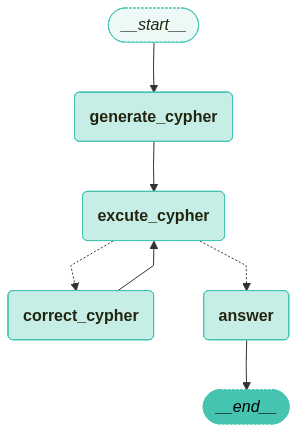

In [26]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [27]:
from langchain_teddynote.messages import stream_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"configurable": {"thread_id": random_uuid()}})

In [28]:
while True:
    try:
        user_input = input("질문(q: 종료): ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph(
            graph, {"messages": [{"role": "user", "content": user_input}]}, config
        )
    except:
        break


🔄 Node: generate_cypher 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(coactor:Person) WHERE p.name = 'Tom Hanks' AND coactor.name <> 'Tom Hanks' RETURN DISTINCT coactor.name LIMIT 100MATCH (p:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(coactor:Person) WHERE p.name = 'Tom Hanks' AND coactor.name <> 'Tom Hanks' RETURN DISTINCT coactor.name LIMIT 100###### EXCUTE CYPHER ######
실행 쿼리문 MATCH (p:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(coactor:Person) WHERE p.name = 'Tom Hanks' AND coactor.name <> 'Tom Hanks' RETURN DISTINCT coactor.name LIMIT 100


/var/folders/wn/fz0vz0td5bn8wl7wkrv30x100000gn/T/ipykernel_38479/1476288056.py:28: DeprecationWarning: read_transaction has been renamed to execute_read
  database_output = session.read_transaction(


###### ROUTE QUERY CORRECTION ######
DB 조회 결과 [{'coactor.name': 'Ed Harris'}, {'coactor.name': 'Gary Sinise'}, {'coactor.name': 'Kevin Bacon'}, {'coactor.name': 'Bill Paxton'}, {'coactor.name': 'Parker Posey'}, {'coactor.name': 'Greg Kinnear'}, {'coactor.name': 'Meg Ryan'}, {'coactor.name': 'Steve Zahn'}, {'coactor.name': 'Dave Chappelle'}, {'coactor.name': 'Madonna'}, {'coactor.name': "Rosie O'Donnell"}, {'coactor.name': 'Geena Davis'}, {'coactor.name': 'Lori Petty'}, {'coactor.name': 'Nathan Lane'}, {'coactor.name': 'Liv Tyler'}, {'coactor.name': 'Charlize Theron'}, {'coactor.name': 'Ian McKellen'}, {'coactor.name': 'Audrey Tautou'}, {'coactor.name': 'Paul Bettany'}, {'coactor.name': 'Jim Broadbent'}, {'coactor.name': 'Halle Berry'}, {'coactor.name': 'Hugo Weaving'}, {'coactor.name': 'Helen Hunt'}, {'coactor.name': 'Sam Rockwell'}, {'coactor.name': 'Bonnie Hunt'}, {'coactor.name': 'Patricia Clarkson'}, {'coactor.name': 'James Cromwell'}, {'coactor.name': 'Michael Clarke Duncan'}, {'c